In [6]:
import sympy as sym
import numpy as np
#import pylab as pl
from IPython.display import display, Math, Latex
sym.init_printing(use_unicode=True)
import sympy.utilities.autowrap as symauto

epss,Dels,nus,ta,tb,pa,pb,kappa,kappb,kas,kbs =\
sym.symbols('epsilon Delta nus ta tb pa pb kappaa kappab kas kbs',real=True)
kapp1a,kapp1b,Las,Lbs = \
sym.symbols('kappa1a kappa1b Las Lbs',real=True)

#Functions for evaluation
Ema = sym.exp(sym.I*(-nus*ta+pa))
Emb = sym.exp(sym.I*(-nus*tb+pb))
Epa = sym.exp(sym.I*(nus*ta+pa))
Epb = sym.exp(sym.I*(nus*tb+pb))
dma = kappa-sym.I*(nus-Dels) + kas*Epa         #d_{-,a}(\nu)
dmb = kappb-sym.I*(nus+Dels) + kbs*Epb         #d_{-,b}(\nu)
dpa = kappa-sym.I*(nus+Dels) + kas*sym.conjugate(Ema)   #d_{+,a}(\nu)
dpb = kappb-sym.I*(nus-Dels) + kbs*sym.conjugate(Emb)   #d_{+,b}(\nu)
Lab = sym.Abs(epss)**2 - dpa*dmb          #\Lambda_{ab}(\nu)
Lba = sym.Abs(epss)**2 - dpb*dma          #\Lambda_{ba}(\nu)

#Expectation value of the outgoing photon number
nom_ba = (kappa+kas*sym.cos(pa-nus*ta)-kapp1a*Las)*(kappb+kbs*sym.cos(pb+nus*tb))
nom_ab = (kappb+kbs*sym.cos(pb+nus*tb)-kapp1b*Lbs)*(kappa+kas*sym.cos(pa-nus*ta))
term_ba  = 2*epss**2*(sym.diff(nom_ba/(Lab*sym.conjugate(Lab)),pa)+sym.diff(nom_ba/(Lab*sym.conjugate(Lab)),pb))
term_ab  = 2*epss**2*(sym.diff(nom_ab/(Lba*sym.conjugate(Lba)),pa)+sym.diff(nom_ab/(Lba*sym.conjugate(Lba)),pa))
deriv_ba = sym.lambdify((nus,epss,Dels,kappa,kappb,kapp1a,kapp1b,kas,kbs,ta,tb,pa,pb,Las,Lbs), term_ba, modules="numpy")
deriv_ab = sym.lambdify((nus,epss,Dels,kappa,kappb,kapp1a,kapp1b,kas,kbs,ta,tb,pa,pb,Las,Lbs), term_ab, modules="numpy")
#diffp   = sym.Rational(1,2)*(sym.diff(I_pexp,pa)-sym.diff(I_pexp,pb))
#diffm   = sym.Rational(1,2)*(sym.diff(I_mexp,pa)-sym.diff(I_mexp,pb))


In [10]:
sens(0.75,0,10,10,0.5,0.5,1.8833,1.8833,0,0,0,0,nu,nup)

/home/nnem614/Documents/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/ma/core.py:2717: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


In [8]:
import numpy as np
#%matplotlib inline
import matplotlib.pyplot as plt
import scipy.integrate as integ
from matplotlib.colors import LogNorm
from IPython.core.debugger import Tracer
#Tracer()() #this one triggers the debugger

def sens(x,delta,kapa,kapb,ra,rb,kta,ktb,phia,phib,La,Lb,nus,nups):
# Function to determine the phase sensitivity of the setup
    import time
    start  = time.clock()

    ## Parameters from inputs ##
    kapa  = kapa*2*np.pi
    kapb  = kapb*2*np.pi
    La    = La/100.
    Lb    = Lb/100.
    phia  = phia*np.pi
    phib  = phib*np.pi
    taua  = kta/kapa
    taub  = ktb/kapa
    Del   = delta*kapa
    eps   = -x*kapa
    kap1a = kapa * ra                         #\kappa_{1,a} (coupling on the right hand side in mode a)
    kap1b = kapb * rb                         #\kappa_{1,b} (coupling on the right hand side in mode b)
    kap2a = kapa * (1-ra)                     #\kappa_{2,a} (coupling on the left hand side in mode a)
    kap2b = kapb * (1-rb)                     #\kappa_{2,b} (coupling on the left hand side in mode b)

    ka = 2*np.sqrt(ra*(1-ra)*(1-La))*kapa    #k_a (feedback strength in mode a)
    kb = 2*np.sqrt(rb*(1-rb)*(1-Lb))*kapb    #k_b (feedback strength in mode b)
    
    ### EXPRESSIONS ###
    def Ei(nu,t,phi):
        return np.exp(1j*(nu*t+phi))
    def d(nu,t,phi,kap,Del,k): #dpa if Del&phi, dma if -Del&-phi, dmb if Del&-phi, dpb if -Del&phi
        return kap - 1j*(nu+Del) + k*Ei(nu,t,-phi)
    def Lab(nu):
        return abs(eps)**2 - d(nu,taua,phia,kapa,Del,ka)*d(nu,taub,-phib,kapb,Del,kb)
    def Lba(nu):
        return abs(eps)**2 - d(nu,taub,phib,kapb,-Del,kb)*d(nu,taua,-phia,kapa,-Del,ka)
    def fa(nu,kap1,kap2): #alpha if quantities for a, 1 if kap1=kap1
        return np.sqrt(2*kap1) + np.sqrt(2*kap2*(1-La))*Ei(nu,taua,phia)
    def fb(nu,kap1,kap2): #alpha if quantities for a, 1 if kap1=kap1
        return np.sqrt(2*kap1) + np.sqrt(2*kap2*(1-Lb))*Ei(nu,taub,phib)

    def Da(nu): #Da if p is for b
        return np.sqrt(1-La)*Lba(nu)*Ei(nu,taua,phia) + d(nu,taub,phib,kapb,-Del,kb)*\
    fa(nu,kap1a,kap2a)*fa(nu,kap2a,kap1a)
    def Db(nu): #Da if p is for b
        return np.sqrt(1-Lb)*Lab(nu)*Ei(nu,taub,phib) + d(nu,taua,phia,kapa,Del,ka)*\
    fb(nu,kap1b,kap2b)*fb(nu,kap2b,kap1b)

    def Ea(nu): # Da if p is for b
        return np.sqrt(La)*(np.sqrt(2*kap2a)*d(nu,taub,phib,kapb,-Del,kb)*fa(nu,kap2a,kap1a) + Lba(nu))
    def Eb(nu): # Da if p is for b
        return np.sqrt(Lb)*(np.sqrt(2*kap2b)*d(nu,taua,phia,kapa,Del,ka)*fb(nu,kap2b,kap1b) + Lab(nu))

    def U1ab(nu): # for U1ab p means b
        return np.real(np.abs(fa(-nu,kap2a,kap1a))**2*(np.abs(fb(nu,kap1b,kap2b))**2+2*kap2b*Lb)/np.abs(Lab(nu))**2)
    def V1ba(nup): # for U1ab p means b
        return np.real((np.abs(Da(nup))**2+np.abs(Ea(nup))**2)/np.abs(Lba(nup))**2)
    def U2ab(nu): # for U2ab p means b
        return np.real(np.conjugate(fa(-nu,kap2a,kap1a))*\
    (fb(nu,kap1b,kap2b)*np.conjugate(Db(nu))+np.sqrt(2*kap2b*Lb)*np.conjugate(Eb(nu)))/np.abs(Lab(nu))**2)
    def V2ba(nup): # for U2ab p means b
        return np.real(fb(-nup,kap2b,kap1b)*(np.conjugate(fa(-nup,kap1a,kap2a))*Da(nup)+np.sqrt(2*kap2a*La)*Ea(nup))/\
    np.abs(Lba(nup))**2)
    def U1ba(nu): # for U1ab p means b
        return np.real(np.abs(fb(-nu,kap2b,kap1b))**2*(np.abs(fa(nu,kap1a,kap2a))**2+2*kap2a*La)/np.abs(Lba(nu))**2)
    def V1ab(nup): # for U1ab p means b
        return np.real((np.abs(Db(nup))**2+np.abs(Eb(nup))**2)/np.abs(Lab(nup))**2)
    def U2ba(nu): # for U2ab p means b
        return np.real(np.conjugate(fb(-nu,kap2b,kap1b))*\
    (fa(nu,kap1a,kap2a)*np.conjugate(Da(nu))+np.sqrt(2*kap2a*La)*np.conjugate(Ea(nu)))/np.abs(Lba(nu))**2)
    def V2ab(nup): # for U2ab p means b
        return np.real(fb(-nup,kap2a,kap1a)*(np.conjugate(fb(-nup,kap1b,kap2b))*Db(nup)+np.sqrt(2*kap2b*Lb)*Eb(nup))/\
    np.abs(Lab(nup))**2)
    
    def num1(nu):
        return np.real(np.abs(eps)**2*(np.abs(fa(-nu,kap2a,kap1a))**2/np.abs(Lab(nu))**2*(np.abs(fb(nu,kap1b,kap2b))**2+\
                                                                                          2*kap2b*Lb)))
    def num2(nu):
        return np.real(np.abs(eps)**2*(np.abs(fb(-nu,kap2b,kap1b))**2/np.abs(Lba(nu))**2*(np.abs(fa(nu,kap1a,kap2a))**2+\
                                                                                          2*kap2a*La)))
    
    N=len(nus)
    #nus[int((N-1)/2)]=0
#    plt.figure(1)
#    plt.plot(nus[int((N-1)/2):(N+1)],F1(nus[int((N-1)/2):(N+1)]),label = "F_1")
#    plt.plot(nus[0:int((N+1)/2)],F2(nus[0:int((N+1)/2)]),label = "F_2")
#    plt.xlim(-20,20)
#    plt.plot(nus[0:int((N+1)/2)],F3(nus[0:int((N+1)/2)]),label = "F_3")
#    plt.plot(nus[int((N-1)/2):(N+1)],F4(nus[int((N-1)/2):(N+1)]),label = "F_4")
#    plt.legend()
#    plt.grid(True)
    
    U1ab_int = integ.quad(U1ab,-2000,0)
    V1ba_int = integ.quad(V1ba,0,2000)
    U2ab_int = integ.quad(U2ab,-2000,0)
    V2ba_int = integ.quad(V2ba,0,2000)
    V1ab_int = integ.quad(V1ab,-2000,0)
    U1ba_int = integ.quad(U1ba,0,2000)
    V2ab_int = integ.quad(V2ab,-2000,0)
    U2ba_int = integ.quad(U2ba,0,2000)
    F1 = U1ab_int[0]*V1ba_int[0]-U2ab_int[0]*V2ba_int[0]
    F2 = U1ba_int[0]*V1ab_int[0]-U2ba_int[0]*V2ab_int[0]
    N1_int = integ.quad(num1,-2000,-0.0)
    N2_int = integ.quad(num1,0,2000.0)
#    F1_int = integ.quad(F1,0,np.inf)
#    F2_int = integ.quad(F2,-np.inf,0)
#    F3_int = integ.quad(F3,-np.inf,0)
#    F4_int = integ.quad(F4,0,np.inf)

    def uncert1(nu,nup):
        return 1/np.abs(Lba(nup))**2*(U1ab(nup)+U2ab(nup))*1/np.abs(Lab(nu))**2*(U3ab(nu)+U4ab(nu))
    def uncert2(nu,nup):
        return 1/np.abs(Lab(nup))**2*(U1ba(nup)+U2ba(nup))*1/np.abs(Lba(nu))**2*(U3ba(nu)+U4ba(nu))
       
    nu1,nup1 = np.meshgrid(nus[int((N-1)/2):(N+1)],nups[0:int((N+1)/2)])
    nu2,nup2 = np.meshgrid(nus[0:int((N+1)/2)],nups[int((N-1)/2):(N+1)])

    def N_ba(nu):
        return np.real(deriv_ba(nu,eps,Del,kapa,kapb,kap1a,kap1b,ka,kb,taua,taub,phia,phib,La,Lb))
    def N_ab(nu):
        return np.real(deriv_ab(nu,eps,Del,kapa,kapb,kap1a,kap1b,ka,kb,taua,taub,phia,phib,La,Lb))
#    plt.plot(nu,deriv_ba(2*np.pi*nu,eps,Del,kapa,kapb,kap1a,kap1b,ka,kb,taua,taub,phia,phib,La,Lb))
#    plt.plot(nu,N_ba(2*np.pi*nu))

    Gder_ba = integ.quad(N_ba,0,2000)
    Gder_ab = integ.quad(N_ab,-2000,0)
#    plt.plot(nus,N_ba(nus))
#    plt.figure(2)
#    plt.contourf(nu2,nup2,np.real(uncert1(2*np.pi*nu2,2*np.pi*nup2)),400,cmap=plt.cm.jet,norm = LogNorm())
#    plt.contourf(nu1,nup1,np.real(uncert2(2*np.pi*nu1,2*np.pi*nup1)),400,cmap=plt.cm.jet,norm = LogNorm())
#    plt.colorbar()
 #   plt.figure(2)
 #   plt.contourf(nu,nup,denom(nu,nup),400,cmap=plt.cm.jet,norm = LogNorm())
 #   plt.figure(3)
    return F1+F2, N1_int[0]+N2_int[0], np.real(Gder_ab[0]-Gder_ba[0])**2
nu = np.linspace(-100,100,501)
nup = np.linspace(-100,100,501)

#sens(0.75,0,10,10,0.5,0.5,1.8833,1.8833,0,0.0,1,1,nu,nup)
#sens(0.5,0,10,10,0.933,0.933,0,0,1.,1.,90,90,nu,nup)
#deriv_ba = sym.lambdify((nus,epss,Dels,kappa,kappb,kapp1a,kapp1b,kas,kbs,ta,tb,pa,pb,Las,Lbs), term_ba, modules="numpy")
#deriv_ab = sym.lambdify((nus,epss,Dels,kappa,kappb,kapp1a,kapp1b,kas,kbs,ta,tb,pa,pb,Las,Lbs), term_ab, modules="numpy")
sens(0.01,5,10,10,0,0,0,0,0,0,100,100,nu,nup)


In [64]:
a=4
if a!=4:
    print(a)

In [91]:
import sympy as sym


24536028.576835286

/home/nnem614/Documents/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in true_divide
/home/nnem614/Documents/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:45: RuntimeWarning: divide by zero encountered in true_divide


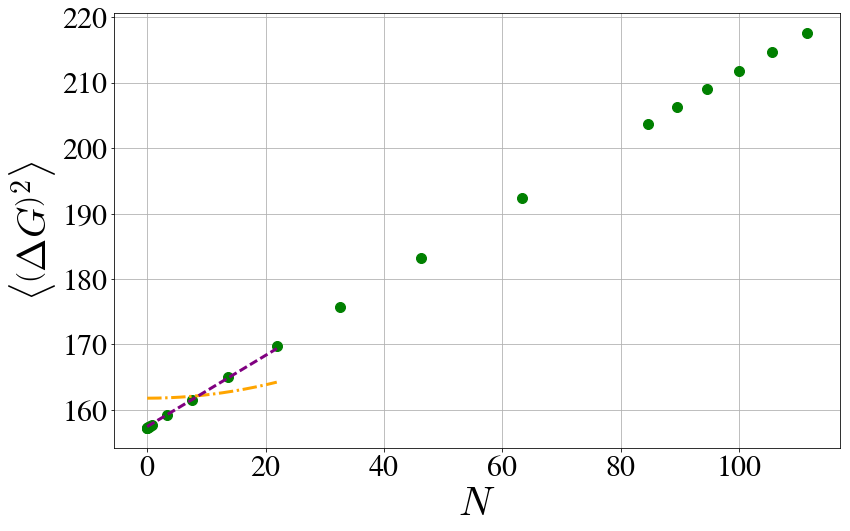

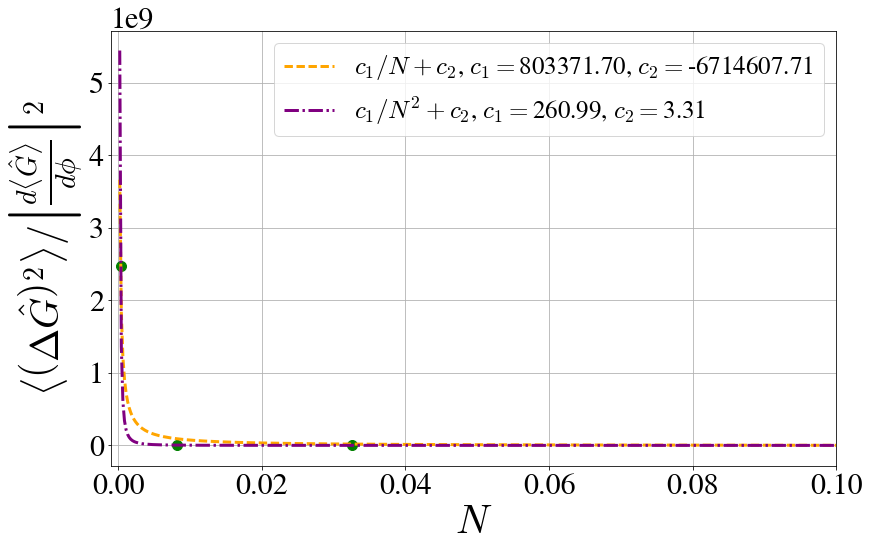

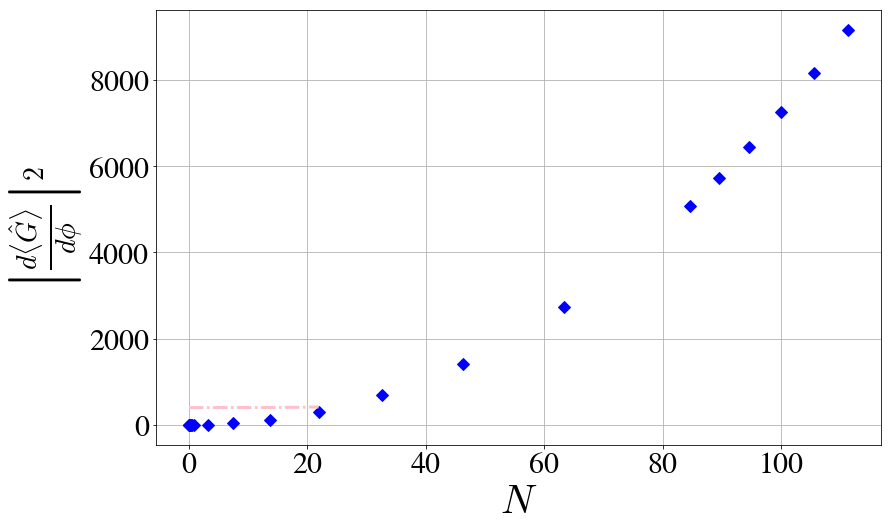

In [9]:
%matplotlib inline
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('font',family='FreeSerif')
mpl.rc('xtick',labelsize=30)
mpl.rc('ytick',labelsize=30)

colors={'red':(241/255.,88/255.,84/255.),\
        'orange':(250/255,164/255.,58/255.),\
        'pink':(241/255,124/255.,176/255.),\
        'brown':(178/255,145/255.,47/255.),\
        'purple':(178/255,118/255.,178/255.),\
        'green':(96/255,189/255.,104/255.),\
        'blue':(93/255,165/255.,218/255.),\
        'yellow':(222/255., 207/255., 63/255),\
        'black':(0.,0.,0.)}
fsfont = {'fontname':'FreeSerif'}

#L=np.array([1,2,3,4,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95])
#eps=np.array([0.01,0.02,0.03,0.04,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.60,0.65,0.70,0.71,0.72,0.73,0.74,0.75])
eps=np.array([0.001,0.005,0.01,0.02,0.03,0.04,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.46,0.47,0.48,0.49,0.5])
#eps=np.array([0.01,0.02,0.03,0.04,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.92,0.94,0.96,0.98,0.99])
#F=np.zeros(len(L))
#N=np.zeros(len(L))
#Gder=np.zeros(len(L))
F=np.zeros(len(eps))
N=np.zeros(len(eps))
Gder=np.zeros(len(eps))

nu = np.linspace(-100,100,11)
nup = np.linspace(-100,100,11)

#for i in range(0,len(L)):
for i in range(0,len(eps)):
#F[i],N[i],Gder[i] = sens(0.5,0,10,10,0.933,0.933,0,0,1.,1.0,L[i],L[i],nu,nup)
    #F[i],N[i],Gder[i] = sens(eps[i],0,10,10,0.933,0.933,0,0,1.,1.0,2,2,nu,nup)
    #F[i],N[i],Gder[i] = sens(eps[i],0,10,10,0.01,0.01,0,0,0.,0.0,100,100,nu,nup)
#    F[i],N[i],Gder[i] = sens(0.75,0,10,10,0.5,0.5,1.8833,1.8833,0.,0.0,L[i],L[i],nu,nup)
    F[i],N[i],Gder[i] = sens(eps[i],0,10,10,0.5,0.5,1.8833,1.8833,0.,0.0,50,50,nu,nup)

def func(x,a,c):
    return a*x**2+c
def func2(x,a,c):
    return a*x+c
def func3(x,a,c):
    return a/(x)+c
def func4(x,a,c):
    return a/(x)**2+c
def func6(x,a,c):
    return a/x**3+c
def func5(x,a,c):
    return a*x**4+c

line = np.linspace(0,N[int(len(N)/2)],100000)
popt, pcov = curve_fit(func, N[0:], F[0:])
popt2, pcov2 = curve_fit(func2, N, F)
popt3, pcov3 = curve_fit(func3, N[:], F[:]/Gder[:])
popt4, pcov4 = curve_fit(func4, N[:], F[:]/Gder[:])
#popt6, pcov6 = curve_fit(func6, N[:], F[:]/Gder[:])
popt5, pcov5 = curve_fit(func5, N[:], Gder[:])

plt.figure(1,figsize=(13,8))
plt.plot(N,F,color='green',marker='o',markersize=10,lw=3,ls='')
plt.grid(True)
plt.plot(line,func(line,*popt),color = 'orange',lw=3,ls='dashdot')
plt.plot(line,func2(line,*popt2),color='purple',lw=3,ls='dashed')
#plt.xlim(0,20000)
#plt.ylim(0,1000)
plt.xlabel('$N$',fontsize = 40,**fsfont)
plt.ylabel('$\langle\left(\Delta G\\right)^2\\rangle$',fontsize = 40,**fsfont)
plt.figure(2,figsize=(13,8))
plt.plot(N,F/Gder,color='green',marker='o',markersize=10,lw=2,ls='')
#plt.ylim(-0.01,8)
plt.xlim(-0.001,0.1)
plt.grid(True)
plt.xlabel('$N$',fontsize = 40,**fsfont)
plt.ylabel('$\langle\left(\Delta \hat{G}\\right)^2\\rangle/\left|\\frac{d\langle\hat{G}\\rangle}{d\phi}\\right|^2$',\
           fontsize = 40,**fsfont)
plt.plot(line,func3(line,*popt3),color='orange',lw=3,ls='--',label="$c_1/N+c_2$, $c_1=$%.2f, $c_2=$%.2f" % (popt3[0],popt3[1]))
plt.plot(line,func4(line,*popt4),color='purple',lw=3,ls='-.',label="$c_1/N^2+c_2$, $c_1=$%.2f, $c_2=$%.2f" % (popt4[0],popt4[1]))
#plt.plot(line,func6(line,*popt6),color='yellow',lw=3,ls='-',label="$a/N^3+b$, $a=$%.2f, $b=$%.2f" % (popt6[0],popt6[1]))
plt.legend(fontsize=25)
plt.figure(3,figsize=(13,8))
plt.plot(N,Gder,color='blue',marker='D',markersize=8,lw=2,ls='')
#plt.xlim(-5,200)
plt.grid(True)
plt.xlabel('$N$',fontsize = 40,**fsfont)
plt.ylabel('$\left|\\frac{d\langle\hat{G}\\rangle}{d\phi}\\right|^2$',fontsize = 40,**fsfont)
plt.plot(line,func5(line,*popt5),color='pink',lw=3,ls='-.')

#plt.plot(line,func3(line,*popt3),color='brown',lw=3,ls='--')
#plt.plot(line,func4(line,*popt4),color='pink',lw=3,ls='-.')
#print("pcov3",np.sqrt(np.diag(pcov3)),"\npcov4",np.sqrt(np.diag(pcov4)))

## Scott's suggestion
1) Determining where the Pyragas type feedback gives back the same as the case without feedback in a one-sided cavity.

In [22]:
import sympy as sym
x = sym.symbols("x")
sym.solve(2*sym.sqrt(x*(1-x))-.125,x)

[0.00392162917538926, 0.996078370824611]

In [9]:
import numpy as np
from scipy.optimize import fsolve

kap = 2*10*np.pi
kap1 = 0.933012701892219*kap
kap2 = 0.0669872981077807*kap

def f1(L):
    return np.sqrt(2*kap1)-np.sqrt(2*kap2*(1-L))
def f2(L):
    return np.sqrt(2*kap2)-np.sqrt(2*kap1*(1-L))
def d(L):
    return kap*(1-np.sqrt(1-L)/2.) 
def Lam(L):
    return kap**2/4-d(L)**2
def D(L):
    return -np.sqrt(1-L)*Lam(L) + d(L)*f1(L)*f2(L)
def E(L):
    return np.sqrt(L)*(Lam(L) + np.sqrt(2*kap2)*d(L)*f2(L))
def M(L):
    return -(f2(L)*(D(L)*np.conjugate(f1(L))+np.sqrt(2*L*kap2)*E(L)))
def N(L):
    return kap*(np.abs(f2(L))**2*(np.abs(f1(L))**2+2*L*kap2))
def eq(L):
    return 4*kap/2*kap/(kap+kap/2)**2+kap/2*(2*np.real(M(L))+N(L))/np.abs(Lam(L))**2
Lv=fsolve(eq,0.06)
print(Lv,eq(Lv))
#print(10*np.log10(1-4*kap/2*kap/(kap+kap/2)**2))
#print(np.abs(Lam(0.001))**2+kap/2*(2*np.real(M(0.001))+N(0.001)))

[ 0.06128224] [  9.96980276e-14]


1. $\ $
2. Changing the phase a little bit in the expression and see how much the spectra change as a result of that.

In [11]:
from pylab import *
import numpy as np
import matplotlib.pyplot as plt


#Function to determine the two-mode squeezing with coherent unidirectional feedback connecting the two sides
def Squeez(eps,theta,Del,kapa,ra,kta,phia,La,thetapa,kapb,rb,ktb,phib,Lb,thetapb,nu):
	kap1a = kapa * ra                         #\kappa_{1,a} (coupling on the right hand side in mode a)
	kap1b = kapb * rb                         #\kappa_{1,b} (coupling on the right hand side in mode b)
	kap2a = kapa * (1-ra)                     #\kappa_{2,a} (coupling on the left hand side in mode a)
	kap2b = kapb * (1-rb)                     #\kappa_{2,b} (coupling on the left hand side in mode b)
	ka = 2*sqrt(ra*(1-ra)*(1-La/100.))*kapa    #k_a (feedback strength in mode a)
	kb = 2*sqrt(rb*(1-rb)*(1-Lb/100.))*kapb    #k_b (feedback strength in mode b)
	ta    = kta/kapa                           #\tau_a (time delay in mode a)
	tb    = ktb/kapb                           #\tau_b (time delay in mode b)
	N    = int(len(nu))                           #\tau_b (time delay in mode b)

	### EXPRESSIONS ###
	Ema = np.exp(1j*(-nu*ta+phia))
	Emb = np.exp(1j*(-nu*tb+phib))
	Epa = np.exp(1j*(nu*ta+phia))
	Epb = np.exp(1j*(nu*tb+phib))
	dma = kapa-1j*(nu-Del) + ka*Epa         #d_{-,a}(\nu)
	dmb = kapb-1j*(nu+Del) + kb*Epb         #d_{-,b}(\nu)
	dpa = kapa-1j*(nu+Del) + ka*conj(Ema)   #d_{+,a}(\nu)
	dpb = kapb-1j*(nu-Del) + kb*conj(Emb)   #d_{+,b}(\nu)
	Lab = abs(eps)**2 - dpa*dmb          #\Lambda_{ab}(\nu)
	Lba = abs(eps)**2 - dpb*dma          #\Lambda_{ba}(\nu)

	alpha1p = sqrt(2*kap1a)+sqrt(2*kap2a*(1-La/100.))*Epa   #\alpha_1(\nu)
	alpha2p = sqrt(2*kap2a)+sqrt(2*kap1a*(1-La/100.))*Epa   #\alpha_2(\nu)
	beta1p  = sqrt(2*kap1b)+sqrt(2*kap2b*(1-Lb/100.))*Epb   #\beta_1(\nu)
	beta2p  = sqrt(2*kap2b)+sqrt(2*kap1b*(1-Lb/100.))*Epb   #\beta_2(\nu)
	alpha1m = sqrt(2*kap1a)+sqrt(2*kap2a*(1-La/100.))*Ema   #\alpha_1(-\nu)
	alpha2m = sqrt(2*kap2a)+sqrt(2*kap1a*(1-La/100.))*Ema   #\alpha_2(-\nu)
	beta1m  = sqrt(2*kap1b)+sqrt(2*kap2b*(1-Lb/100.))*Emb   #\beta_1(-\nu)
	beta2m  = sqrt(2*kap2b)+sqrt(2*kap1b*(1-Lb/100.))*Emb   #\beta_2(-\nu)

	Da  = sqrt(1-La/100.)*Lba*Epa+dpb*alpha1p*alpha2p
	Db  = sqrt(1-Lb/100.)*Lab*Epb+dpa*beta1p*beta2p
	Ea  = sqrt(La/100.)*(sqrt(2*kap2a)*dpb*alpha2p+Lba)
	Eb  = sqrt(Lb/100.)*(sqrt(2*kap2b)*dpa*beta2p+Lab)
	Mba = exp(1j*(theta-(thetapa+thetapb)/2))*alpha2m*(Db*np.conj(beta1p)+sqrt(2*Lb/100.*kap2b)*Eb)
	Mab = exp(1j*(theta-(thetapa+thetapb)/2))*beta2m*(Da*np.conj(alpha1p)+sqrt(2*La/100.*kap2a)*Ea)
	Nba = abs(eps)*(np.abs(alpha2m)**2*(np.abs(beta1p)**2+2*Lb/100.*kap2b)+\
	np.abs(beta2p)**2*(np.abs(alpha1m)**2+2*La/100.*kap2a))
	Nab = abs(eps)*(np.abs(beta2m)**2*(np.abs(alpha1p)**2+2*La/100.*kap2a)+\
	np.abs(alpha2p)**2*(np.abs(beta1m)**2+2*Lb/100.*kap2b))
	### CORRELATIONS ###
	ncorrm = abs(eps)*(1/np.abs(Lab)**2*(2*np.real(Mba)+Nba))  #(normalized)
	ncorrp = abs(eps)*(1/np.abs(Lba)**2*(2*np.real(Mab)+Nab))   #(normalized)
#	Soutm  = 10*np.log10(1.+ncorrm)
#	Soutp  = 10*np.log10(1.+ncorrp)
	Sout   = np.zeros(N)
	Sout[0:int(N/2)]  = 10*np.log10(1.+ncorrm[0:int(N/2)])
	Sout[int(N/2):N]  = 10*np.log10(1.+ncorrp[int(N/2):N])
	return Sout#,Soutm,Soutp

def Sth(eps,kapa,Del,theta,phia,nu):
    N = len(nu)
    Sout_th1=np.zeros(len(nu))
#    Sout_th1[int(N/2):N] = 10*np.log10(1+4*np.abs(eps)*kapa*(np.cos((theta+phia-np.pi)/2)**2/((np.abs(eps)-kapa)**2+(nu[int(N/2):N]-Del)**2)-\
#                                                     np.sin((theta+phia-np.pi)/2)**2/((np.abs(eps)+kapa)**2+(nu[int(N/2):N]-Del)**2)))    
#    Sout_th1[0:int(N/2)] = 10*np.log10(1+4*np.abs(eps)*kapa*(np.cos((theta+phia-np.pi)/2)**2/((np.abs(eps)-kapa)**2+(nu[0:int(N/2)]+Del)**2)-\
#                                                      np.sin((theta+phia-np.pi)/2)**2/((np.abs(eps)+kapa)**2+(nu[0:int(N/2)]+Del)**2)))
    Sout_th1[int(N/2):N] = 10*np.log10(1+4*np.abs(eps)*kapa*(np.cos((theta+phia)/2)**2/((np.abs(eps)-kapa)**2+(nu[int(N/2):N]-Del)**2)-\
                                                     np.sin((theta+phia)/2)**2/((np.abs(eps)+kapa)**2+(nu[int(N/2):N]-Del)**2)))    
    Sout_th1[0:int(N/2)] = 10*np.log10(1+4*np.abs(eps)*kapa*(np.cos((theta+phia)/2)**2/((np.abs(eps)-kapa)**2+(nu[0:int(N/2)]+Del)**2)-\
                                                      np.sin((theta+phia)/2)**2/((np.abs(eps)+kapa)**2+(nu[0:int(N/2)]+Del)**2)))
    return Sout_th1

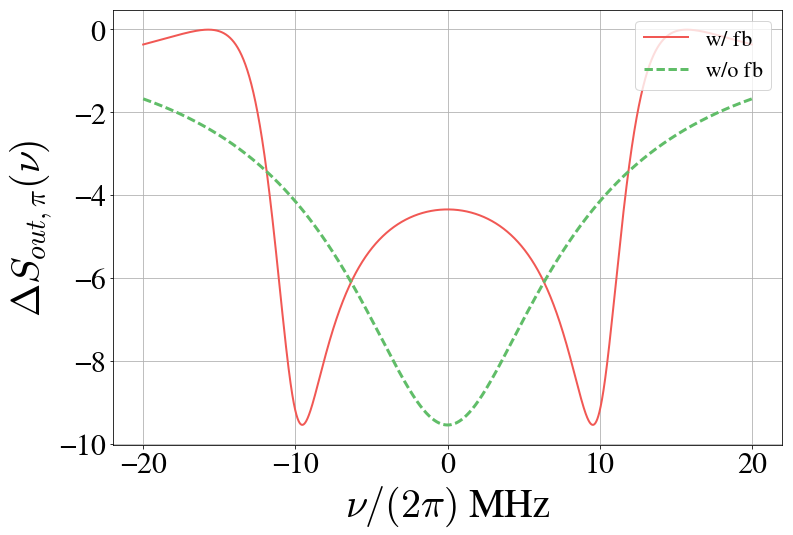

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('font',family='FreeSerif')
mpl.rc('xtick',labelsize=30)
mpl.rc('ytick',labelsize=30)

colors={'red':(241/255.,88/255.,84/255.),\
        'orange':(250/255,164/255.,58/255.),\
        'pink':(241/255,124/255.,176/255.),\
        'brown':(178/255,145/255.,47/255.),\
        'purple':(178/255,118/255.,178/255.),\
        'green':(96/255,189/255.,104/255.),\
        'blue':(93/255,165/255.,218/255.),\
        'yellow':(222/255., 207/255., 63/255),\
        'black':(0.,0.,0.)}
collab = ["yellow","red","green","purple","blue","pink","brown","orange","black"]
ls = ["-","--","-.",":","-","--","-.",":"]
lw = [5,3,3,4,2,4]
fsfont = {'fontname':'FreeSerif',"fontsize":40}

nu = np.linspace(-20,20,100001)
vec = np.array([0.000000001,0.00000001,0.0000001,0.000001,0.00001,0.0001])#,0.001,0.01,0.1])#
#def Squeez(eps,theta,Del,kapa,ra,kta,phia,La,thetapa,kapb,rb,ktb,phib,Lb,thetapb,nu):
plt.figure(1,figsize=(12,8))
#for i in range(0,len(vec)):
#    phia = np.pi + vec[i]
#    phia = vec[i]
 #   print(phia)
#    logphi = np.log10(vec[i])
    #print(logphi)
#    Sfb = (Squeez(0.5*10*2*np.pi,np.pi,0,10*2*np.pi,0.933012701892219,0,phia,0.06128224*100,0,\
#             2*10*np.pi,0.933012701892219,0,np.pi,0.06128224*100,0,nu*2*np.pi)-\
#    Squeez(0.5*10*2*np.pi,np.pi,0,10*2*np.pi,0.933012701892219,0,np.pi,0.06128224*100,0,\
#             2*10*np.pi,0.933012701892219,0,np.pi,0.06128224*100,0,nu*2*np.pi))/(phia-np.pi)
#    Snf = (Sth(0.5*10*2*np.pi,10*2*np.pi,0,np.pi,phia,nu*2*np.pi)-\
#           Sth(0.5*10*2*np.pi,10*2*np.pi,0,np.pi,np.pi,nu*2*np.pi))/(phia-np.pi)
#    Sfb = (Squeez(0.5*10*2*np.pi,np.pi,0,10*2*np.pi,0.5,2,phia,0.1174*100,0,\
#             2*10*np.pi,0.5,2,0,0.1174*100,0,nu*2*np.pi)-\
#    Squeez(0.5*10*2*np.pi,np.pi,0,10*2*np.pi,0.5,2,0,0.1174*100,0,\
#             2*10*np.pi,0.5,2,0,0.1174*100,0,nu*2*np.pi))/(phia)
#    Snf = (Sth(0.5*10*2*np.pi,10*2*np.pi,0,np.pi,phia,nu*2*np.pi)-\
#           Sth(0.5*10*2*np.pi,10*2*np.pi,0,np.pi,0,nu*2*np.pi))/(phia)

#    plt.plot(nu,Sfb,color=colors[collab[i]],ls=ls[i],lw=lw[i],\
#             label="w/ fb $\Delta\\phi_a = 10^{%d}$" % logphi)
#Snf = (Sth(0.5*10*2*np.pi,10*2*np.pi,0,np.pi,.0001,nu*2*np.pi)-\
#       Sth(0.5*10*2*np.pi,10*2*np.pi,0,np.pi,0,nu*2*np.pi))/(phia)
#Snf = (Sth(0.5*10*2*np.pi,10*2*np.pi,0,np.pi,np.pi+.0001,nu*2*np.pi)-\
#       Sth(0.5*10*2*np.pi,10*2*np.pi,0,np.pi,np.pi,nu*2*np.pi))/(phia)
Sfb = Squeez(0.5*10*2*np.pi,np.pi,0,10*2*np.pi,0.5,2,0,0.1174*100,0,\
             2*10*np.pi,0.5,2,0,0.1174*100,0,nu*2*np.pi)
Snf = Sth(0.5*10*2*np.pi,10*2*np.pi,0,np.pi,0,nu*2*np.pi)
#Snf = Sth(0.5*10*2*np.pi,10*2*np.pi,0,np.pi,np.pi,nu*2*np.pi)
#Sfb = Squeez(0.5*10*2*np.pi,np.pi,0,10*2*np.pi,0.933012701892219,0,np.pi,0.06128224*100,0,\
#             2*10*np.pi,0.933012701892219,0,np.pi,0.06128224*100,0,nu*2*np.pi)

#    plt.plot(nu,Snf,color=colors[collab[i+3]],ls=ls[i+3],lw=lw[i+3],\
#             label="w/o fb $\Delta\\phi_a = 10^{%d}$" % logphi)
#plt.plot(nu,Snf,color=colors[collab[-1]],lw=3,label="w/o fb $\Delta\\phi_a = 10^{-4}$")
plt.plot(nu,Sfb,color=colors[collab[1]],lw=2,label="w/ fb")
plt.plot(nu,Snf,color=colors[collab[2]],lw=3,ls="--",label="w/o fb")
#plt.plot(nu,Snf[int(len(nu)/2)]+0*nu)
plt.grid(True)
plt.xlabel("$\\nu/(2\pi)$ MHz",**fsfont)
plt.ylabel("$\Delta S_{out,\pi}(\\nu)$",**fsfont)
plt.legend(fontsize=22,loc="upper right")

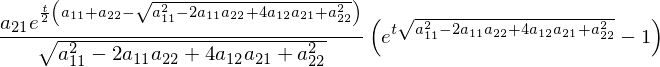

In [3]:
import sympy as sym

sym.init_printing()
M,a11,a12,a21,a22,t=sym.symbols("M a_{11} a_{12} a_{21} a_{22} t")
M = sym.Matrix([[a11,a12],[a21,a22]])
D=sym.simplify(sym.exp(M*t))
D[1,0]

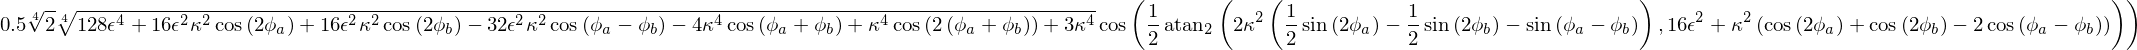

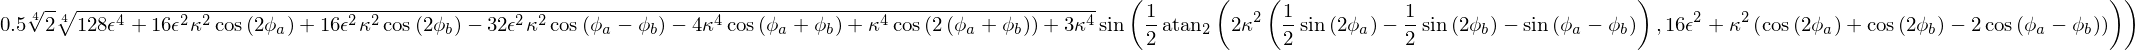

KeyboardInterrupt: 

In [33]:
import sympy as sym
from IPython.display import display
sym.init_printing()

kap,kap2,eps,phia,phib = sym.symbols("\kappa \kappa_2 \epsilon \phi_a \phi_b",real=True)
pa = sym.symbols("p_a")
pa = 0.5*sym.sqrt(kap**2*(sym.exp(sym.I*phia)-sym.exp(-sym.I*phib))**2+16*eps**2)
R = kap*(2-.5*(sym.cos(phia)+sym.cos(phib)))
par = sym.trigsimp(sym.re(pa))
pai = sym.trigsimp(sym.im(pa))
G = 8*eps**2*R*kap2*kap*.5*(sym.cos(phia)-sym.cos(phib))/((R**2-par**2)*(R**2+pai**2))
display(par)
display(pai)
sym.simplify(.5*(sym.diff(G,phia)-sym.diff(G,phib)))

In [1]:
import numpy as np
def G(reps,kapa,kapb,ra,rb,Las,Lbs,phia,phib):
    kap2a = (1-ra)*kapa
    kap1a = ra*kapa
    kap1b = rb*kapb
    kap2b = (1-rb)*kapb
    eps   = reps*kapa
    La    = Las/100.
    Lb    = Lbs/100.
    ka    = 2*np.sqrt(kap1a*kap2a*(1-La))
    kb    = 2*np.sqrt(kap1b*kap2b*(1-Lb))
    
    R  = kapa + kapb - ka*np.cos(phia) - kb*np.cos(phib)
    p  = np.sqrt((kapa-ka*np.exp(1j*phia)-kapb+kb*np.exp(-1j*phib))**2 + 4*eps**2)
    pr = np.real(p)
    pi = np.imag(p)
#    print((R**2-pr**2))
#    print(kapa**2)

    return 8*eps**2*R / ((R**2-pr**2)*(R**2+pi**2)) * (kap2a*(kapb-kb*np.cos(phib))-kap2b*(kapa-ka*np.cos(phia)))

def delG2(reps,kapa,kapb,ra,rb,Las,Lbs,phia,phib):
    kap2a = (1-ra)*kapa
    kap1a = ra*kapa
    kap1b = rb*kapb
    kap2b = (1-rb)*kapb
    eps   = reps*kapa
    La    = Las/100.
    Lb    = Lbs/100.
    ka    = 2*np.sqrt(kap1a*kap2a*(1-La))
    kb    = 2*np.sqrt(kap1b*kap2b*(1-Lb))
    
    R   = kapa + kapb - ka*np.cos(phia) - kb*np.cos(phib)
    p   = np.sqrt((kapa-ka*np.exp(1j*phia)-kapb+kb*np.exp(-1j*phib))**2 + 4*eps**2)
    pr  = np.real(p)
    pi  = np.imag(p)
    l1K = 0.5*(kapa-kapb - (ka*np.exp(1j*phia)-kb*np.exp(-1j*phib)) + p)
    l2K = 0.5*(kapa-kapb - (ka*np.exp(1j*phia)-kb*np.exp(-1j*phib)) - p)
    Na  = 8*kap2a*eps**2*R * (kapb-kb*np.cos(phib)) / ((R**2-pr**2)*(R**2+pi**2))
    Nb  = 8*kap2b*eps**2*R * (kapa-ka*np.cos(phia)) / ((R**2-pr**2)*(R**2+pi**2))
    Qa  = 2*(2*kap2a/np.abs(p)**2 * (kapa-ka*np.cos(phia)) * \
            (np.abs(l1K)**2/(R+pr)+np.abs(l2K)**2/(R-pr)-l1K*np.conjugate(l2K)/(R+1j*pi)-l2K*np.conjugate(l1K)/(R-1j*pi))-\
            (2*kap2a-ka*np.cos(phia)) + 1)
    Qb  = 2*(2*kap2b/np.abs(p)**2 * (kapb-kb*np.cos(phib)) * \
            (np.abs(l1K)**2/(R-pr)+np.abs(l2K)**2/(R+pr)-l1K*np.conjugate(l2K)/(R-1j*pi)-l2K*np.conjugate(l1K)/(R+1j*pi))-\
            (2*kap2b-kb*np.cos(phib)) + 1)
    #print(Na*Qa)
    #print(Nb*Qb)
    alp = 4*np.sqrt(kap2a*kap2b)/np.abs(p)**2*(kapb-kb*np.cos(phib))*(-eps)*\
    (l1K*(1/(R-pr)-1/(R-1j*pi)) + l2K*(1/(R+pr)-1/(R+1j*pi)))
    #print(alp)
    gam = -4*np.sqrt(kap2a*kap2b)/np.abs(p)**2*(kapa-ka*np.cos(phia))*(-eps)*\
    (l1K*(1/(R+pr)-1/(R+1j*pi)) + l2K*(1/(R-pr)-1/(R-1j*pi)))
    #print(gam)
    #print(2*alp*gam)
    #print(Na*Qa+Nb*Qb)
    
    return Na+Nb,Na*Qa + Nb*Qb - 2*np.real(alp*gam)

Delphi = np.array([10**(-2),10**(-3),10**(-4),10**(-5),10**(-6),10**(-2)])

#for i in range(0,len(Delphi)):
#    print((G(0.49,10*2*np.pi,10*2*np.pi,0.933012701892219,0.933012701892219,0,0,Delphi[i],0)-\
#           G(0.49,10*2*np.pi,10*2*np.pi,0.933012701892219,0.933012701892219,0,0,0,0))/Delphi[i])
#    print(G(0.45,10*2*np.pi,10*2*np.pi,0.933012701892219,0.933012701892219,0,0,Delphi[i],0))
#    print(G(0.5,10*2*np.pi,10*2*np.pi,0.933012701892219,0.933012701892219,0,0,0,0))
#    print(Delphi[i])
Gder = (G(0.48,10*2*np.pi,10*2*np.pi,0.933012701892219,0.933012701892219,0,0,Delphi[-1],0)-\
           G(0.48,10*2*np.pi,10*2*np.pi,0.933012701892219,0.933012701892219,0,0,0,0))/Delphi[-1]

Gdel2 = delG2(0.49,10*2*np.pi,10*2*np.pi,0.933012701892219,0.933012701892219,0,0,0,0)
#rint(np.sqrt(Gdel2[1]/np.abs(Gder)**2))
#rint(1/Gdel2[0])
print(Gdel2[0])
print(np.sqrt(Gdel2[1]))
print(np.abs(Gder))


204.154656764
(103.237120328+0j)
0.2471377032


## Homodyne detection

1.0
R 2.0
pr 1.0
pi 1.0000000004
homos 0.0
R2-pr2 -0.923076923077
R2-pi2 1.0
(R2+pr2)(R2-pi2) -1.08333333333
? -20.3080545577
-0.0 -5684.89213503


/home/nnem614/Documents/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in true_divide


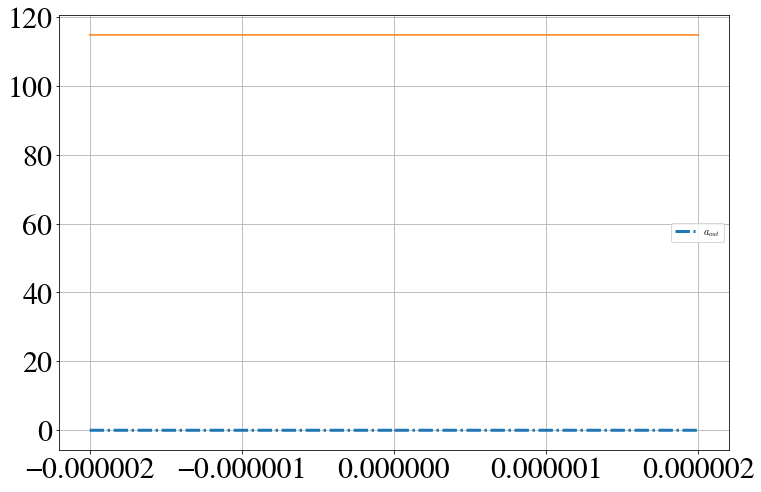

In [74]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('font',family='FreeSerif')
mpl.rc('xtick',labelsize=30)
mpl.rc('ytick',labelsize=30)

colors={'red':(241/255.,88/255.,84/255.),\
        'orange':(250/255,164/255.,58/255.),\
        'pink':(241/255,124/255.,176/255.),\
        'brown':(178/255,145/255.,47/255.),\
        'purple':(178/255,118/255.,178/255.),\
        'green':(96/255,189/255.,104/255.),\
        'blue':(93/255,165/255.,218/255.),\
        'yellow':(222/255., 207/255., 63/255),\
        'black':(0.,0.,0.)}
collab = ["yellow","red","green","purple","blue","pink","brown","orange","black"]
ls = ["-","--","-.",":","-","--","-.",":"]
lw = [5,3,3,4,2,4]
fsfont = {'fontname':'FreeSerif',"fontsize":40}

kap=2*np.pi*10
r1 = 0.5
#r1 = 0.933012701892219
#r1=0.984122918275927
#r1=0.996078370824611
kap2 = (1-r1)*kap
L  = 0/100.
k = 2*np.sqrt(kap2*r1*kap*(1-L))
print(k/kap)
eps = 0.6*kap
def R(phi):
    return 2*kap - k*(1+np.cos(phi))
print("R",R(np.pi*(1+0.0000005))/kap+1/4*0.0000005**2*np.pi**2)
def p(phi):
    return np.sqrt(k**2*(1-np.exp(-1j*phi))**2+4*eps**2)
print("pr",(np.real(p(np.pi*(1+0.0000005)))**2+k**2/(k**2+eps**2)*(2*k**2+3*eps**2)*0.0000005**2*np.pi**2)/4/(k**2+eps**2))
print("pi",(np.imag(p(np.pi*(1+0.0000005)))**2/0.0000005**2/np.pi**2/k**4*(k**2+eps**2)))
def homo1(phi):
    return 16*kap2*(kap+k)*eps**2*R(phi)/(R(phi)**2-np.real(p(phi))**2)/(R(phi)**2+np.imag(p(phi))**2)
def homo2(phi):
    return 16*kap2*(kap+k*np.cos(phi))*eps**2*R(phi)/(R(phi)**2-np.real(p(phi))**2)/(R(phi)**2+np.imag(p(phi))**2)
def homo3(phi):
    return 16*kap2*(kap-k)*eps**2*R(phi)/(R(phi)**2-np.real(p(phi))**2)/(R(phi)**2+np.imag(p(phi))**2)
print("homos",16*(kap-k)*(R(np.pi*(1+0.00005))+k*0.00005**2*np.pi**2/2)/kap**2)
def homo4(phi):
    return 16*kap2*(kap-k*np.cos(phi))*eps**2*R(phi)/(R(phi)**2-np.real(p(phi))**2)/(R(phi)**2+np.imag(p(phi))**2)
def sq(phi):
    return kap2+4*eps*kap2/(R(phi)**2-np.real(p(phi))**2)/(R(phi)**2+np.imag(p(phi))**2)*\
(2*eps*R(phi)**2-((kap-k)*np.real(R(phi)**2+1j*np.real(p(phi))*np.imag(p(phi))-R(phi)*k*(np.exp(-1j*phi)-1))+\
                 (kap-k*np.cos(phi))*np.real(R(phi)**2-1j*np.real(p(phi))*np.imag(p(phi))+R(phi)*k*(np.exp(1j*phi)-1))))
print("R2-pr2",(R(np.pi*(1+0.0000005))**2-np.real(p(np.pi*(1+0.0000005)))**2)/\
      ((3*kap**2-4*eps**2)-kap**2/2/(kap**2+4*eps**2)*(kap**2+2*eps**2)*0.0000005**2*np.pi**2))
print("R2-pi2",(R(np.pi*(1+0.0000005))**2+np.imag(p(np.pi*(1+0.0000005)))**2)/\
      ((4*kap**2)-kap**2/2/(kap**2+4*eps**2)*(kap**2+8*eps**2)*0.0000005**2*np.pi**2))
print("(R2+pr2)(R2-pi2)",1/((R(np.pi*(1+0.0000005))**2-np.real(p(np.pi*(1+0.0000005)))**2)*\
      (R(np.pi*(1+0.0000005))**2+np.imag(p(np.pi*(1+0.0000005)))**2))/
      (1/(4*(3*kap**2-4*eps**2)*kap**2)*(1+1/(2*(kap**2+4*eps**2)*4*(3*kap**2-4*eps**2))*\
                                        (7*kap**4+28*eps**2*kap**2-32*eps**4)*0.0000005**2*np.pi**2)))
print("?",homo3(np.pi*(1+0.0000005))-(4*kap2*eps**2/(3*kap**2-4*eps**2)+\
                                      kap2*eps**2/2/(kap**2*3-4*eps**2)**2/(kap**2+4*eps**2)*\
                                     (-4*kap**4-20*eps**2*kap**2+16*eps**4)))
#phiv = np.linspace(0.5,1.5,100001)
phiv = np.linspace(-2,2,100000)*10**(-6)
#plt.figure(1, figsize=(12,8))
#plt.plot(phiv,np.real(p(np.pi*phiv)),lw=3,ls="--",label="$Rep$")
#plt.plot(phiv,np.imag(p(np.pi*phiv)),lw=3,ls="--",label="$Imp$")
#plt.plot(phiv,R(np.pi*phiv),lw=3,ls="-",label="$R$")
#plt.plot(phiv,homo2(np.pi*phiv),lw=3,ls="-.",label="$a_{out}$")
#plt.plot(phiv,sq(np.pi*phiv),lw=3,ls="-.",label="squeez")
#plt.grid(True)
#plt.legend()
print(homo2(np.pi),R(np.pi)**2-np.real(p(np.pi))**2)
#print(homo1(0),homo2(0),sq(0))
#plt.figure(2,figsize = (12,8))
#plt.plot(phiv,R(np.pi*phiv)**2-np.real(p(np.pi*phiv))**2,lw=3,ls="-",label="$R^2-pr^2$")
#plt.plot(phiv,R(np.pi*phiv)**2+np.imag(p(np.pi*phiv))**2,lw=3,ls="-",label="$R^2+pi^2$")
#plt.grid(True)
#plt.legend()
plt.figure(3, figsize=(12,8))
#plt.plot(phiv,homo2(np.pi*phiv),lw=3,ls="-.",label="$a_{out}$")
#plt.plot(phiv,homo3(np.pi*phiv),lw=3,ls="-.",label="$a_{out}$")
#plt.plot(phiv,4*kap2*eps**2/(3*kap**2-4*eps**2)+\
#         2*kap2*eps**2/(3*kap**2-4*eps**2)**2/(kap**2+4*eps**2)*(kap**4+5*eps**2*kap**2-4*eps**4)*(np.pi*(phiv-1))**2)
plt.grid(True)
plt.legend()
#plt.figure(4, figsize=(12,8))
#plt.plot(phiv,homo1(np.pi*phiv),lw=3,ls="-.",label="$a_{out}$")
#plt.plot(phiv,-2*kap-(4*kap**2-eps**2)/eps**2*kap2*(np.pi*(phiv-1))**2)
#plt.grid(True)
#plt.legend()

plt.show()


In [7]:
print(np.sqrt(1+1j))
print(np.sqrt(np.abs(1+1j))*np.exp(1j*np.angle(1+1j)/2))

(1.09868411347+0.455089860562j)
(1.09868411347+0.455089860562j)


In [ ]:
from pylab import *
import numpy as np
import matplotlib.pyplot as plt


#Function to determine the two-mode squeezing with coherent unidirectional feedback connecting the two sides
def Squeez(eps,theta,Del,kapa,ra,kta,phia,La,thetapa,kapb,rb,ktb,phib,Lb,thetapb,nu):
	kap1a = kapa * ra                         #\kappa_{1,a} (coupling on the right hand side in mode a)
	kap1b = kapb * rb                         #\kappa_{1,b} (coupling on the right hand side in mode b)
	kap2a = kapa * (1-ra)                     #\kappa_{2,a} (coupling on the left hand side in mode a)
	kap2b = kapb * (1-rb)                     #\kappa_{2,b} (coupling on the left hand side in mode b)
	ka = 2*sqrt(ra*(1-ra)*(1-La/100.))*kapa    #k_a (feedback strength in mode a)
	kb = 2*sqrt(rb*(1-rb)*(1-Lb/100.))*kapb    #k_b (feedback strength in mode b)
	ta    = kta/kapa                           #\tau_a (time delay in mode a)
	tb    = ktb/kapb                           #\tau_b (time delay in mode b)
	N    = int(len(nu))                           #\tau_b (time delay in mode b)

	### EXPRESSIONS ###
	Ema = np.exp(1j*(-nu*ta+phia))
	Emb = np.exp(1j*(-nu*tb+phib))
	Epa = np.exp(1j*(nu*ta+phia))
	Epb = np.exp(1j*(nu*tb+phib))
	dma = kapa-1j*(nu-Del) + ka*Epa         #d_{-,a}(\nu)
	dmb = kapb-1j*(nu+Del) + kb*Epb         #d_{-,b}(\nu)
	dpa = kapa-1j*(nu+Del) + ka*conj(Ema)   #d_{+,a}(\nu)
	dpb = kapb-1j*(nu-Del) + kb*conj(Emb)   #d_{+,b}(\nu)
	Lab = abs(eps)**2 - dpa*dmb          #\Lambda_{ab}(\nu)
	Lba = abs(eps)**2 - dpb*dma          #\Lambda_{ba}(\nu)

	alpha1p = sqrt(2*kap1a)+sqrt(2*kap2a*(1-La/100.))*Epa   #\alpha_1(\nu)
	alpha2p = sqrt(2*kap2a)+sqrt(2*kap1a*(1-La/100.))*Epa   #\alpha_2(\nu)
	beta1p  = sqrt(2*kap1b)+sqrt(2*kap2b*(1-Lb/100.))*Epb   #\beta_1(\nu)
	beta2p  = sqrt(2*kap2b)+sqrt(2*kap1b*(1-Lb/100.))*Epb   #\beta_2(\nu)
	alpha1m = sqrt(2*kap1a)+sqrt(2*kap2a*(1-La/100.))*Ema   #\alpha_1(-\nu)
	alpha2m = sqrt(2*kap2a)+sqrt(2*kap1a*(1-La/100.))*Ema   #\alpha_2(-\nu)
	beta1m  = sqrt(2*kap1b)+sqrt(2*kap2b*(1-Lb/100.))*Emb   #\beta_1(-\nu)
	beta2m  = sqrt(2*kap2b)+sqrt(2*kap1b*(1-Lb/100.))*Emb   #\beta_2(-\nu)

	Da  = sqrt(1-La/100.)*Lba*Epa+dpb*alpha1p*alpha2p
	Db  = sqrt(1-Lb/100.)*Lab*Epb+dpa*beta1p*beta2p
	Ea  = sqrt(La/100.)*(sqrt(2*kap2a)*dpb*alpha2p+Lba)
	Eb  = sqrt(Lb/100.)*(sqrt(2*kap2b)*dpa*beta2p+Lab)
	Mba = exp(1j*(theta-(thetapa+thetapb)/2))*alpha2m*(Db*np.conj(beta1p)+sqrt(2*Lb/100.*kap2b)*Eb)
	Mab = exp(1j*(theta-(thetapa+thetapb)/2))*beta2m*(Da*np.conj(alpha1p)+sqrt(2*La/100.*kap2a)*Ea)
	Nba = abs(eps)*(np.abs(alpha2m)**2*(np.abs(beta1p)**2+2*Lb/100.*kap2b)+\
	np.abs(beta2p)**2*(np.abs(alpha1m)**2+2*La/100.*kap2a))
	Nab = abs(eps)*(np.abs(beta2m)**2*(np.abs(alpha1p)**2+2*La/100.*kap2a)+\
	np.abs(alpha2p)**2*(np.abs(beta1m)**2+2*Lb/100.*kap2b))
	### CORRELATIONS ###
	ncorrm = abs(eps)*(1/np.abs(Lab)**2*(2*np.real(Mba)+Nba))  #(normalized)
	ncorrp = abs(eps)*(1/np.abs(Lba)**2*(2*np.real(Mab)+Nab))   #(normalized)
#	Soutm  = 10*np.log10(1.+ncorrm)
#	Soutp  = 10*np.log10(1.+ncorrp)
	Sout   = np.zeros(N)
	Sout[0:int(N/2)]  = 10*np.log10(1.+ncorrm[0:int(N/2)])
	Sout[int(N/2):N]  = 10*np.log10(1.+ncorrp[int(N/2):N])
	return Sout#,Soutm,Soutp

#def Squeez(eps,theta,Del,kapa,ra,kta,phia,La,thetapa,kapb,rb,ktb,phib,Lb,thetapb,nu):

plt.figure(1,figsize=(12,8))
plt.plot()

1.0
0.673990270633
-94.2477796077


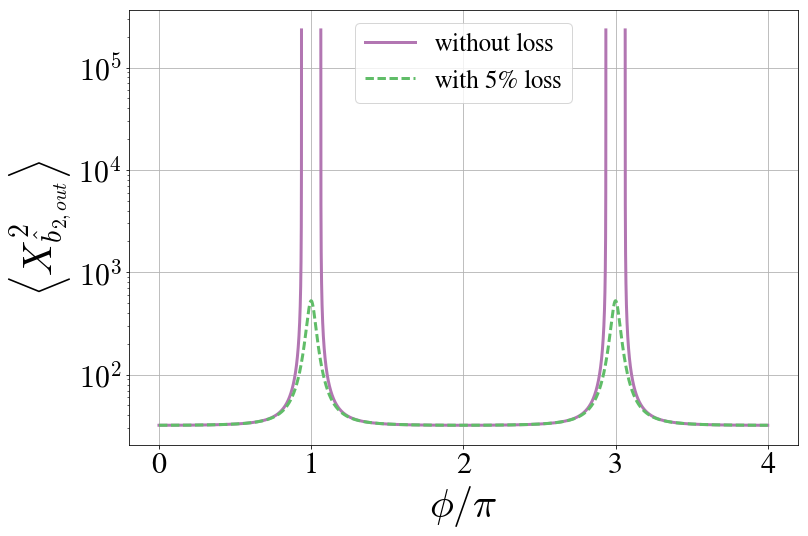

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('font',family='FreeSerif')
mpl.rc('xtick',labelsize=30)
mpl.rc('ytick',labelsize=30)

colors={'red':(241/255.,88/255.,84/255.),\
        'orange':(250/255,164/255.,58/255.),\
        'pink':(241/255,124/255.,176/255.),\
        'brown':(178/255,145/255.,47/255.),\
        'purple':(178/255,118/255.,178/255.),\
        'green':(96/255,189/255.,104/255.),\
        'blue':(93/255,165/255.,218/255.),\
        'yellow':(222/255., 207/255., 63/255),\
        'black':(0.,0.,0.)}
collab = ["yellow","red","green","purple","blue","pink","brown","orange","black"]
ls = ["-","--","-.",":","-","--","-.",":"]
lw = [5,3,3,4,2,4]
fsfont = {'fontname':'FreeSerif',"fontsize":40}

kap=2*np.pi*10
r1 = 0.5
#r1 = 0.933012701892219
#r1=0.984122918275927
#r1=0.996078370824611
kap2 = (1-r1)*kap
L  = 0/100.
def k(L):
    return 2*np.sqrt(kap2*r1*kap*(1-L))
print(k(0)/kap)
eps = 0.1*kap
def R(phi,L):
    return 2*kap + k(L)*(1+np.cos(phi))
print(R(np.pi+0.0000005,0)**2/kap**2/(1+(np.pi+0.0000005)**2/2))
def p(phi,L,eps):
    return np.sqrt(k(L)**2*(1-np.exp(-1j*phi))**2+4*eps**2)

#print(np.real(p(0.0000005,0))**2/(4*eps**2-kap**2/4*0.0000005**2))
def homo1(phi,L,eps):
    return 8*kap2*(kap+k(L))*eps**2*R(phi,L)/(R(phi,L)**2-np.real(p(phi,L,eps))**2)/\
(R(phi,L)**2+np.imag(p(phi,L,eps))**2)
def homo2(phi,L,eps):
    return 8*kap2*(kap+k(L)*np.cos(phi))*eps**2*R(phi,L)/(R(phi,L)**2-np.real(p(phi,L,eps))**2)/\
(R(phi,L)**2+np.imag(p(phi,L,eps))**2)
def homo3(phi,L,eps):
    return 8*kap2*(kap-k(L))*eps**2*R(phi,L)/(R(phi,L)**2-np.real(p(phi,L,eps))**2)/(R(phi,L)**2+np.imag(p(phi,L,eps))**2)
def homo4(phi,L,eps):
    return 8*kap2*(kap-k(L)*np.cos(phi))*eps**2*R(phi,L)/(R(phi,L)**2-np.real(p(phi,L,eps))**2)/\
(R(phi,L)**2+np.imag(p(phi,L,eps))**2)

def homo1th(phi):
    return kap/2*(eps**2)/(4*kap**2-eps**2)*(1+(10*kap**2-eps**2)/8/(4*kap**2-eps**2)*phi**2)
def homo2th(phi):
    return kap/2*(eps**2)/(4*kap**2-eps**2)*(1+(2*kap**2+eps**2)/8/(4*kap**2-eps**2)*phi**2)
def homo3th(phi):
    return 4*kap2*(eps**2)/(kap**2-4*eps**2)*(1-(kap**2-eps**2)/(kap**2-4*eps**2)*phi**2)
def homo4th(phi):
    return 4*kap2*(eps**2)/(kap**2-4*eps**2)*(1-(kap**2+2*eps**2)/2/(kap**2-4*eps**2)*phi**2)
phiv = np.linspace(0,4,100001)
#phiv = np.linspace(-5,5,100000)*10**(-7)
#plt.figure(1, figsize=(12,8))
#plt.plot(phiv,homo1(np.pi*phiv),lw=3,ls="-",label="$b_{out}$")
#plt.plot(phiv,homo1th(np.pi*phiv),lw=3,ls="-.",label="theory")
#plt.grid(True)
#plt.legend()
#plt.figure(2, figsize=(12,8))
#plt.plot(phiv,homo2(np.pi*phiv),lw=3,ls="-",label="$a_{out}$")
#plt.plot(phiv,homo2th(np.pi*phiv),lw=3,ls="-.",label="theory")
#plt.grid(True)
#plt.legend()
#plt.figure(3, figsize=(12,8))
#plt.plot(phiv,homo3(np.pi*phiv,0),lw=3,ls="-.",label="$b_{out}$")
#plt.plot(phiv,homo3th(np.pi*phiv),lw=3,ls="-.",label="theory")
#plt.grid(True)
#plt.legend()
#plt.figure(4, figsize=(12,8))
#plt.plot(phiv,homo4(np.pi*phiv,0),lw=3,ls="-.",label="$a_{out}$")
#plt.plot(phiv,homo4th(np.pi*phiv),lw=3,ls="-.",label="theory")
#plt.grid(True)
#plt.legend()

eps=0.2*kap
plt.figure(5,figsize=(12,8))
plt.semilogy(phiv,2*homo1(phiv*np.pi,0,eps)+kap2,lw=3,label="without loss",color=colors['purple'])
print(2*homo1(np.pi,0,eps)+kap2)
plt.xlabel("$\phi/\pi$",**fsfont)
plt.ylabel("$\left\langle X^2_{\hat{b}_{2,out}}\\right\\rangle$",**fsfont)
plt.semilogy(phiv,2*homo1(phiv*np.pi,5/100.,eps)+kap2,lw=3,ls='--',label="with 5% loss",color=colors['green'])
plt.legend(fontsize=25)
#plt.xlim(0,4)
#plt.ylim(0,20)
plt.grid(True)
#plt.figure(6,figsize=(12,8))
#plt.semilogy(phiv,2*homo1(phiv*np.pi,0,0.1*kap)+kap2,lw=3,label="$|\epsilon|=0.1\kappa, L=0$",color=colors['red'])
#plt.semilogy(phiv,2*homo1(phiv*np.pi,5/100.,0.1*kap)+kap2,lw=3,ls='--',label="$|\epsilon|=0.1\kappa, L=5\%$",\
#         color=colors['blue'])
#plt.semilogy(phiv,2*homo1(phiv*np.pi,0,0.3*kap)+kap2,lw=3,label="$|\epsilon|=0.3\kappa, L=0$",color=colors['purple'])
#plt.semilogy(phiv,2*homo1(phiv*np.pi,5/100.,0.3*kap)+kap2,lw=3,ls='--',label="$|\epsilon|=0.3\kappa, L=5\%$",\
#         color=colors['green'])
#plt.semilogy(phiv,2*homo1(phiv*np.pi,0,0.49*kap)+kap2,lw=3,label="$|\epsilon|=0.49\kappa, L=0$",color=colors['orange'])
#plt.semilogy(phiv,2*homo1(phiv*np.pi,5/100.,0.49*kap)+kap2,lw=3,ls='--',label="$|\epsilon|=0.49\kappa, L=5\%$",\
#         color=colors['pink'])
#plt.xlabel("$\phi/\pi$",**fsfont)
#plt.ylabel("$\left\langle X^2_{\hat{b}_{2,out}}\\right\\rangle$",**fsfont)
#plt.legend(fontsize=25)
#plt.xlim(0,4)
#plt.ylim(0,1000)
#plt.grid(True)


plt.show()


0.500043998064
(31.413162056+3.84767993859e-15j)
(-929.548645915-830.498567074j)
(-929.548645915-830.498567074j)
0.500043998064
(31.413162056+3.84767993859e-15j)
(-929.548645915-830.498567074j)
(-929.548645915-830.498567074j)


/home/nnem614/Documents/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in true_divide
/home/nnem614/Documents/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in true_divide


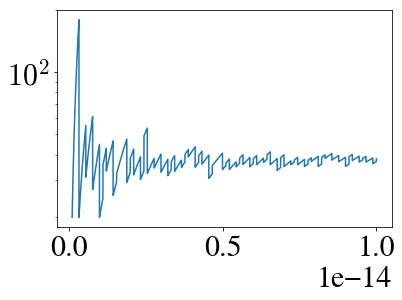

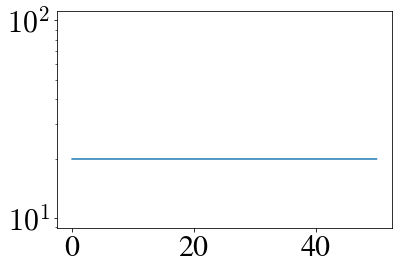

In [47]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('font',family='FreeSerif')
mpl.rc('xtick',labelsize=30)
mpl.rc('ytick',labelsize=30)

def sens(theta,kapa,ra,La,phia,kapb,rb,Lb,phib,alpha,eps,Del,delta):
    kapa  = 2*np.pi*kapa
    kap1a = ra*kapa
    kap2a = kapa-kap1a
    La    = La/100.
    ka    = 2*np.sqrt(kap1a*kap2a*(1-La))
    print(ka/kapa)
    phia  = np.pi*phia
    kapb  = 2*np.pi*kapb
    kap1b = rb*kapb
    kap2b = kapb-kap1b
    Lb    = Lb/100.
    kb    = 2*np.sqrt(kap1b*kap2b*(1-Lb))
    phia  = np.pi*phib
    eps   = eps*kapa
    Del   = Del*kapa
    theta = np.pi*theta
    
    Ka = kapa+1j*Del+ka*np.exp(1j*phia)
    print(Ka)
    Kb = kapb+1j*Del+ka*np.exp(-1j*phib)
    R  = kapa+kapb+ka*np.cos(phia)+kb*np.cos(phib)
    p  = np.sqrt((Ka-Kb)**2+4*eps**2)
    pr = np.real(p)
    pi = np.imag(p)
    da = np.sqrt(2*kap2a) + np.sqrt(2*kap1a*(1-La))*np.exp(1j*phia)
    db = np.sqrt(2*kap2b) + np.sqrt(2*kap1b*(1-Lb))*np.exp(1j*phib)
    
    def noise(delta):
        nt1 = 8*eps**2*R/(R**2-pr**2)/(R**2+pi**2)*((kapa+ka*np.cos(phia)-kap1a*La)*(kb*np.cos(phib+delta))+\
                                                    (kapb+kb*np.cos(phib+delta)-kap1b*Lb)*(ka*np.cos(phia)))
        nt2 = 4*eps/(R**2-pr**2)/(R**2+pi**2)*np.real(np.exp(1j*theta))*da*db*\
        ((kapa+ka*np.cos((phia)))*(R**2+1j*pi*pr-R*(Ka-Kb)) + (kapb+kb*np.cos(phib+delta))*(R**2-1j*pi*pr+R*(Ka-Kb)))
        return 1/2.*(1+nt1+nt2)
    
    def sig(delta):
        st1 = (1/(Ka*Kb-eps**2)*(2*np.sqrt(kap1a*kap2a)+(2*kapa+ka*np.exp(1j*phia))*np.sqrt(1-La)*np.exp(1j*phia))*(Ka-Kb)+\
                               np.sqrt(1-La))*alpha
        print(Ka*Kb-eps**2)
        st2 = -eps*np.exp(1j*theta)/(Ka*Kb-eps**2)*(2*np.sqrt(kap1a*kap2b)+2*np.sqrt(kap2a*kap2b*(1-La))*np.exp(1j*phia) +\
                                     2*np.sqrt(kap1a*kap1b*(1-Lb))*np.exp(-1j*(phib+delta))+\
                                     2*np.sqrt(kap1b*kap2a*(1-La)*(1-Lb))*np.exp(1j*(phia-phib-delta)))
        return 2*np.real(st1+st2)
    
    return np.abs(noise(delta))/np.abs((sig(delta)-sig(0))/delta)**2

plt.figure(1)
delta = np.linspace(0,10**(-14),100000)
plt.semilogy(delta,sens(1,10,.933,0,1,10,.5,0,1,2,0.933,0,delta))
plt.figure(2)
alpha = np.linspace(0.1,50,100000)
plt.semilogy(alpha,sens(1,10,.933,0,1,10,.5,0,1,alpha,0.933,0,10**(-15)))